In [ ]:
# Cell 1:
import networkx as nx
import numpy as np
from queue import PriorityQueue
import ipywidgets as widgets
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import logging
import dgl 
import os 
import random 
import itertools 

# Giả định utils.py chứa MỌI THỨ từ file Original.ipynb
# (MultiHeadDQN, NetworkEnv, ReplayBuffer, evaluate_model, v.v.)
from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *

# --- CUDA DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [2]:
# Cell 2:
import logging
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Configure logging to output to PyCharm's console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def add_node_with_edges(graph, node_name):
    """
    Thêm một node vào đồ thị. 
    Giai đoạn 1: Cho phép người dùng nhập 'priority' cho node mới.
    Giai đoạn 2: Cho phép người dùng nhập các cạnh liên quan.
    """
    # Thêm node (chưa có thuộc tính)
    graph.add_node(node_name)
    
    # Khai báo các widget toàn cục cho hàm này
    global node_dropdown, user_text, root_text, direction_dropdown, output, priority_text_widget
    output = widgets.Output()

    # --- Giai đoạn 2: Logic thêm cạnh (Giữ nguyên) ---
    def add_edge(b):
        with output:
            # (Lấy priority đã lưu để hiển thị lại thông báo)
            current_priority = graph.nodes[node_name].get('priority', 'N/A')
            priority_msg = f"<b>Node:</b> '{node_name}' (Priority={current_priority}).<br><b>Adding Edges:</b>"
            
            clear_output(wait=True)
            display(HTML(priority_msg))
            logger.info(f"Add Edge button clicked for node '{node_name}'.")

            try:
                target_node = node_dropdown.value
                user_prob = float(user_text.value)
                root_prob = float(root_text.value)
                direction = direction_dropdown.value

                if not (0.0 <= user_prob <= 1.0 and 0.0 <= root_prob <= 1.0):
                    display(HTML("<b>Error:</b> Probabilities must be in the range [0.0, 1.0]. Please try again."))
                    logger.error(f"Invalid probabilities: user={user_prob}, root={root_prob}")
                    # Hiển thị lại widget nếu lỗi
                    display_widgets(priority_msg) 
                    return

                edge_info = f"Edge Info: user={user_prob}, root={root_prob}, direction={direction}"

                if direction == "To Target":
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{node_name}' to '{target_node}' ({edge_info})"
                elif direction == "From Target":
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Edge from '{target_node}' to '{node_name}' ({edge_info})"
                else:  # Bidirectional
                    graph.add_edge(node_name, target_node, user=user_prob, root=root_prob)
                    graph.add_edge(target_node, node_name, user=user_prob, root=root_prob)
                    edge_msg = f"Bidirectional edge between '{node_name}' and '{target_node}' ({edge_info})"

                display(HTML(f"<b>Notification:</b> {edge_msg} has been added."))
                logger.info(f"{edge_msg} has been added.")
                # Hiển thị lại widget cho cạnh tiếp theo
                display_widgets(priority_msg) 
            except ValueError:
                display(HTML("<b>Error:</b> Invalid input for probabilities. Please enter valid numbers."))
                logger.error("Invalid input for probabilities.")

    def stop_adding(b):
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Finished adding edges for node '{node_name}'."))
            logger.info(f"Finished adding edges for node '{node_name}'.")

    def display_widgets(priority_msg):
        """Hàm hiển thị Giao diện Giai đoạn 2 (Thêm cạnh)"""
        with output:
            clear_output(wait=True)
            display(HTML(priority_msg)) # Hiển thị lại thông báo node và priority
            
            existing_nodes = list(graph.nodes())
            if not existing_nodes:
                display(HTML("<b>Warning:</b> No existing nodes in the graph."))
                logger.warning("No existing nodes in the graph.")
                return

            global node_dropdown, user_text, root_text, direction_dropdown
            node_dropdown = widgets.Dropdown(options=existing_nodes, description='Target Node:', disabled=False)
            user_text = widgets.FloatText(value=0.0, description='User Prob:', style={'description_width': 'initial'})
            root_text = widgets.FloatText(value=0.0, description='Root Prob:', style={'description_width': 'initial'})
            direction_dropdown = widgets.Dropdown(options=["To Target", "From Target", "Bidirectional"], description='Edge Direction:', disabled=False)
            add_button = widgets.Button(description="Add Edge")
            stop_button = widgets.Button(description="Stop")

            add_button.on_click(add_edge)
            stop_button.on_click(stop_adding)

            display(node_dropdown, user_text, root_text, direction_dropdown, add_button, stop_button)

    # --- Giai đoạn 1: Logic thêm Priority (Mới) ---
    def set_priority(b):
        """Xử lý việc gán priority và chuyển sang Giai đoạn 2"""
        with output:
            try:
                # Lấy giá trị float (hoặc int nếu bạn muốn)
                priority_value = float(priority_text_widget.value) 
                
                # Gán thuộc tính 'priority' cho node
                graph.nodes[node_name]['priority'] = priority_value
                
                msg = f"<b>Notification:</b> Node '{node_name}' added with priority={priority_value}."
                logger.info(f"Node '{node_name}' priority set to {priority_value}.")
                
                # Chuyển sang Giai đoạn 2 (Thêm cạnh)
                # Truyền thông báo mới vào display_widgets
                display_widgets(f"{msg}<br><b>Now adding edges:</b>")
                
            except ValueError:
                clear_output(wait=True)
                display(HTML("<b>Error:</b> Invalid priority. Please enter a valid number."))
                logger.error("Invalid input for priority.")
                # Thử lại Giai đoạn 1
                display_priority_widget() 

    def display_priority_widget():
        """Hàm hiển thị Giao diện Giai đoạn 1 (Thêm Priority)"""
        with output:
            clear_output(wait=True)
            display(HTML(f"<b>Notification:</b> Node '{node_name}' has been added."))
            display(HTML(f"<b>Please set priority for '{node_name}':</b>"))
            
            global priority_text_widget
            priority_text_widget = widgets.FloatText(
                value=0.0, # Giá trị priority mặc định
                description='Priority:',
                style={'description_width': 'initial'}
            )
            
            set_priority_button = widgets.Button(description="Set Priority & Add Edges")
            set_priority_button.on_click(set_priority)
            
            display(priority_text_widget, set_priority_button)

    # --- Khởi chạy ---
    # Bắt đầu bằng cách hiển thị Giai đoạn 1 (Thêm Priority)
    display(output)
    display_priority_widget()

In [3]:
G_1 = nx.DiGraph()
G_1.add_nodes_from(["Data Server", "Pad", "Web Server", "Host 1", "Host 2", "Host 3", "File Server", "Router"])
node_attributes = {
    "Data Server": {"state": 0, "priority": 2}, "Pad": {"state": 0, "priority": 1},
    "Web Server": {"state": 0, "priority": 1}, "Host 1": {"state": 0, "priority": 1},
    "Host 2": {"state": 0, "priority": 0}, "Host 3": {"state": 0, "priority": 0},
    "File Server": {"state": 0, "priority": 0}, "Router": {"state": 0, "priority": 2}
}
nx.set_node_attributes(G_1, node_attributes)
edges = [
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}), ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}), ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}), ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}), ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}), ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}), ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04}), ("Data Server", "File Server", {"user": 0.6, "root": 0.02}),
    ("Router", "Web Server", {"user": 0.9, "root": 0.9}), ("Web Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Router", "Data Server", {"user": 0.9, "root": 0.1}), ("Data Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Pad", "Router", {"user": 0.7, "root": 0.5}),
]
G_1.add_edges_from(edges)


G_new = G_1.copy()
add_node_with_edges(G_new, "New node")


Output()

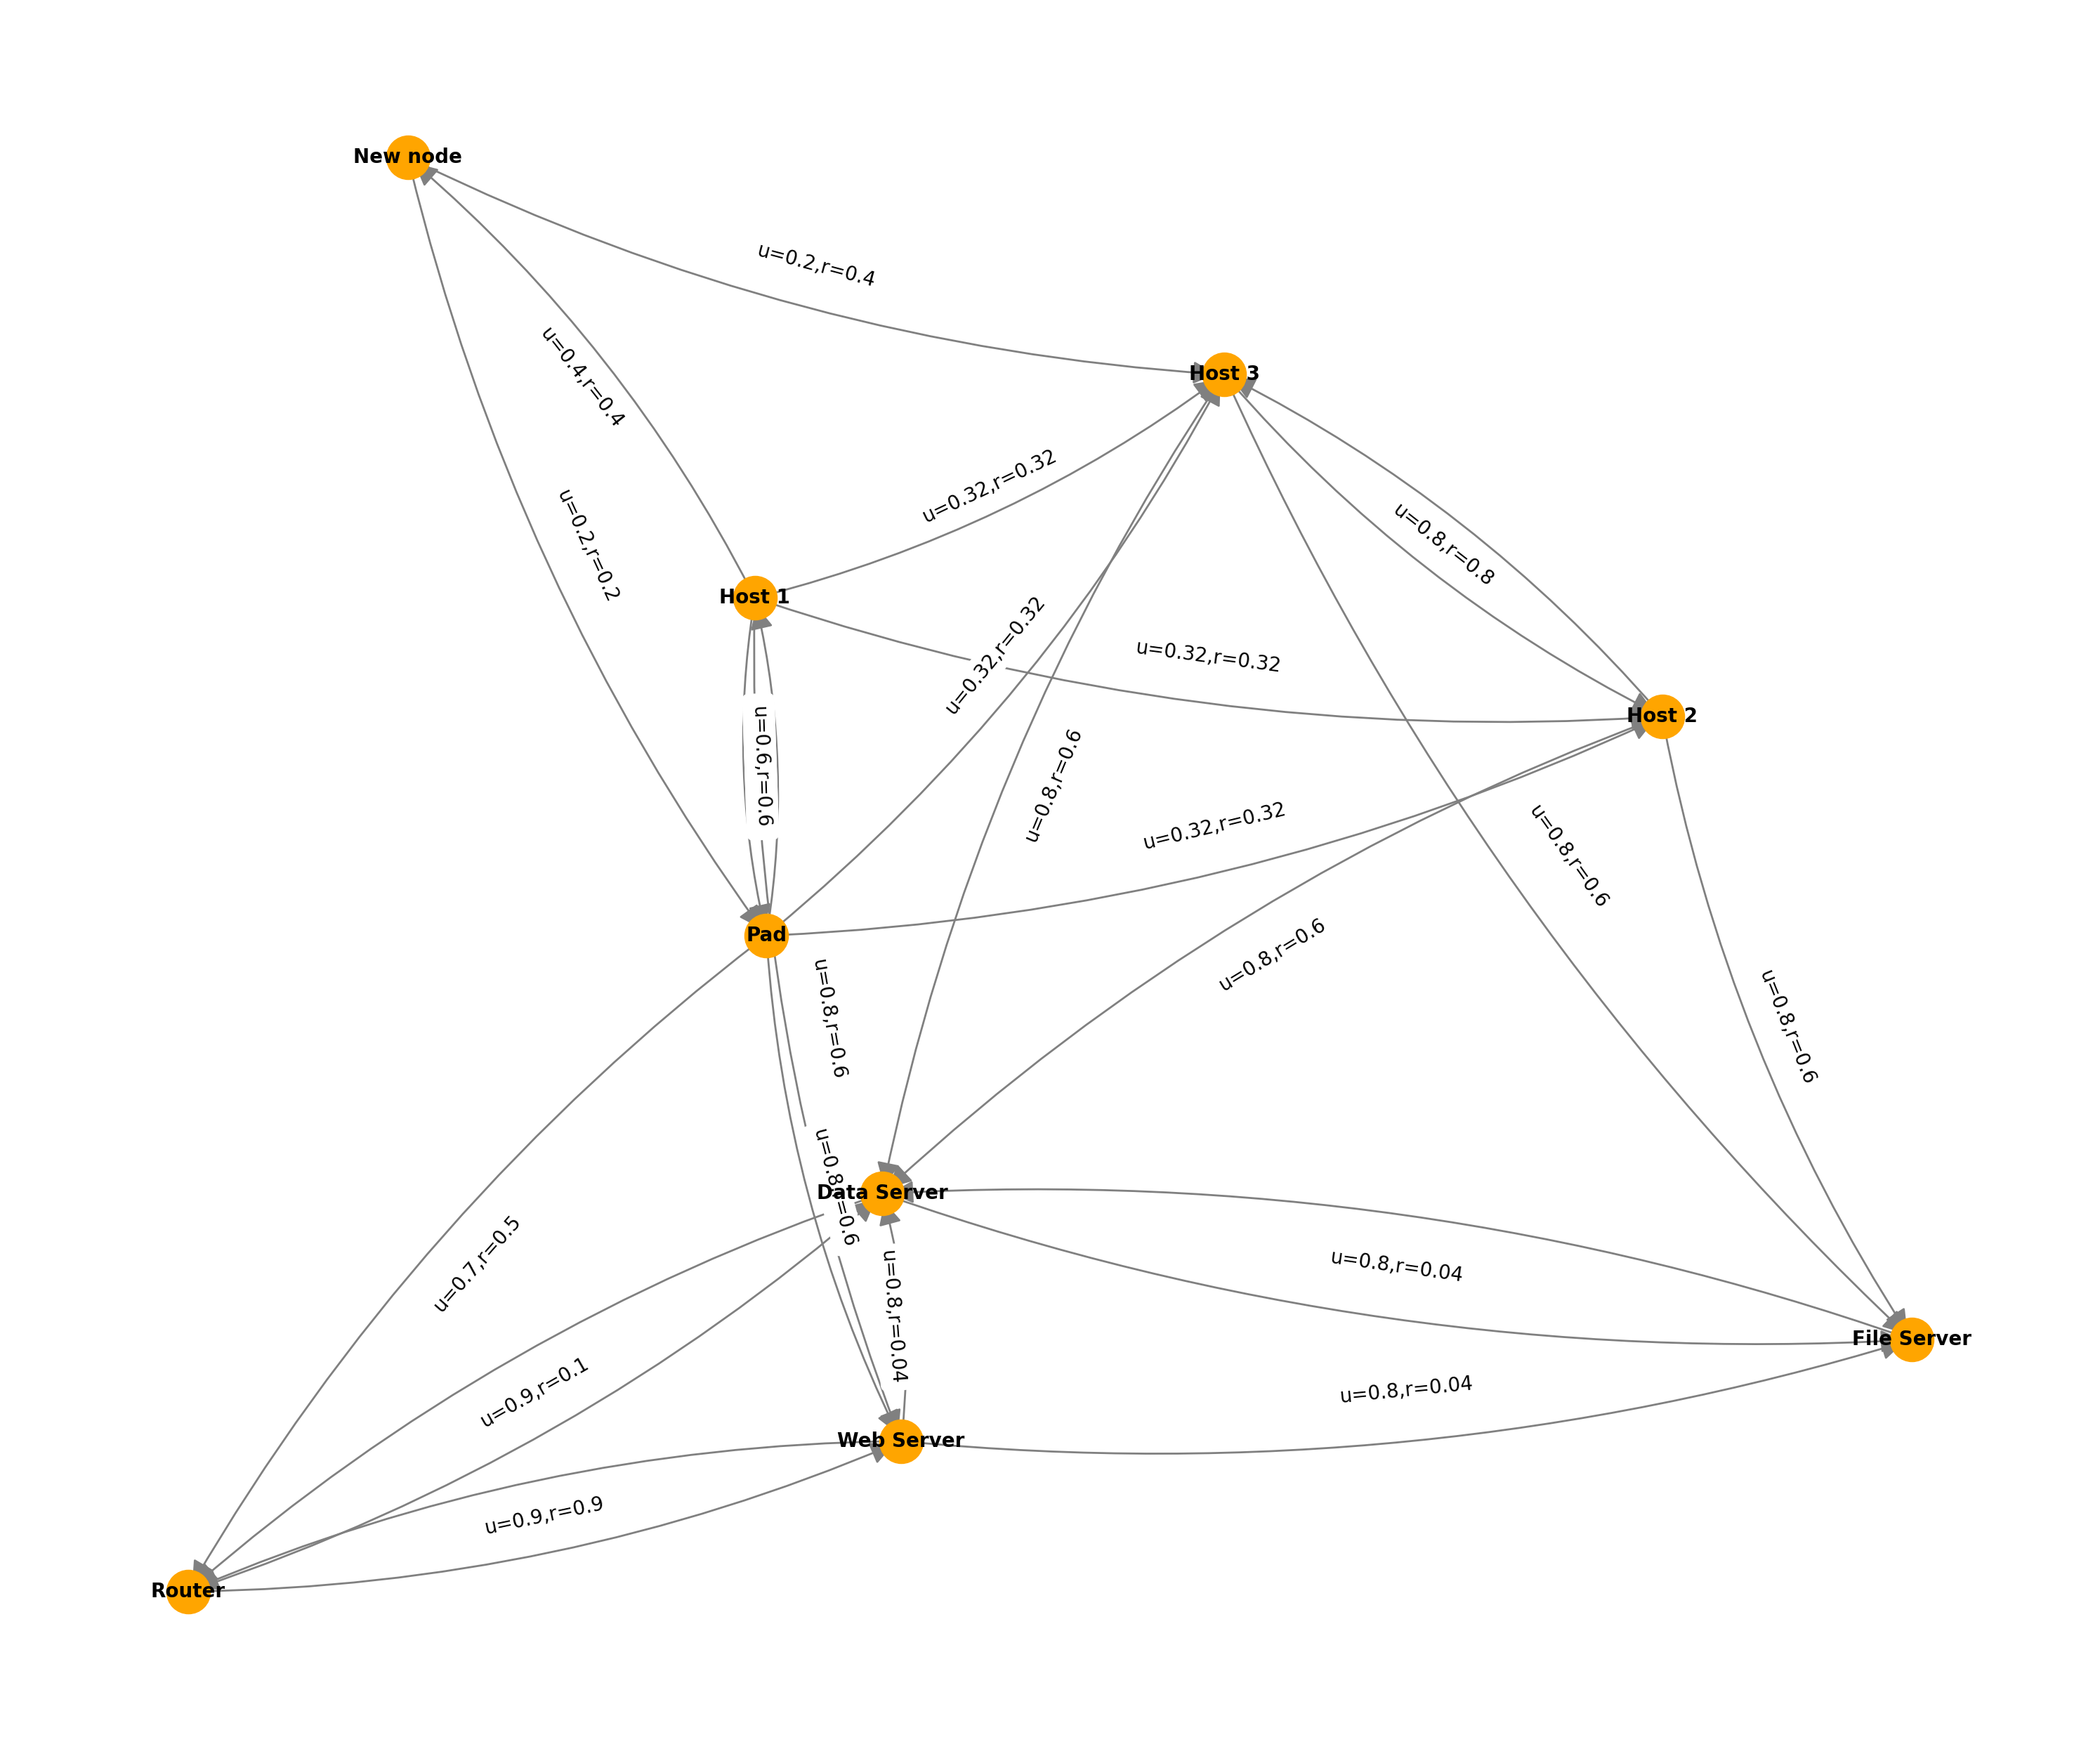

In [15]:
# Cell 4:
plt.figure(figsize=(30, 25))

# Cố định layout để lần nào cũng ra vị trí giống nhau
pos = nx.spring_layout(G_new, seed=42)

# Vẽ nodes
nx.draw_networkx_nodes(G_new, pos, node_color='orange', node_size=2000)

# Vẽ labels nodes
nx.draw_networkx_labels(G_new, pos, font_size=20, font_weight='bold')

# Vẽ edges với mũi tên và màu xám
nx.draw_networkx_edges(
    G_new, pos,
    edge_color='gray',
    arrows=True,
    arrowsize=50,
    width=2,
    connectionstyle='arc3,rad=0.1'  # Cạnh hơi cong cho đẹp
)

# Vẽ label trọng số cạnh
edge_labels = {(u, v): f"u={d['user']},r={d['root']}" for u, v, d in G_new.edges(data=True)}
nx.draw_networkx_edge_labels(G_new, pos, edge_labels=edge_labels, font_size=20)

plt.axis('off')
plt.tight_layout()

plt.savefig("graph_new.png") # Đổi tên file để không ghi đè
plt.show()


In [16]:
# Cell 5: Tải Cấu hình và GNN Encoder (Đã đồng bộ với Graph.ipynb)
import yaml
import torch
import torch.nn.functional as F
from utils.graph_utils import EGraphSAGE, DGI # Giả định class nằm ở đây

print("\n--- Đang tải cấu hình và trọng số GNN ---")

# Định nghĩa đường dẫn (Khớp với Graph.ipynb cell 10)
BASE_PATH = 'graphs'
MODEL_STATE_PATH = f"{BASE_PATH}/dgi_model_state_dict.pth"
CONFIG_FILE_PATH = f"{BASE_PATH}/model_config.yaml"
# File này chứa dữ liệu gốc từ Graph.ipynb (node features cũ)
# Lưu ý: Bạn cần chắc chắn file này tồn tại hoặc lấy từ logic của Graph.ipynb
STATIC_ENV_PATH = f"graphs/1/graph_environment.pth"

try:
    # 1. Tải cấu hình từ YAML (Sửa lỗi load .pth)
    with open(CONFIG_FILE_PATH, 'r') as f:
        config = yaml.safe_load(f)

    print(f"Loaded Config: {config}")

    # 2. Khởi tạo Encoder rỗng với tham số từ config
    encoder = EGraphSAGE(
        config['NDIM_IN'],
        config['EDIM'],
        config['N_HIDDEN'],
        config['N_OUT'],
        config['N_LAYERS'],
        F.leaky_relu,
        device
    )

    # 3. Load trọng số đã train
    dgi_model_to_load = DGI(encoder)
    dgi_model_to_load.load_state_dict(torch.load(MODEL_STATE_PATH, map_location=device))

    # 4. Trích xuất encoder
    trained_encoder = dgi_model_to_load.encoder
    trained_encoder.to(device)
    trained_encoder.eval()

    # Lấy kích thước embedding (ví dụ: 24)
    embedding_dim = config['N_OUT']

    # Hàm tiền xử lý (Giống Original.ipynb)
    MAX_N_FEATURES = config['NDIM_IN']
    MAX_E_FEATURES = config['EDIM']

    def build_batch_tensor(feats, max_dim):
        return feats[:, :max_dim]

    print(f"[THÀNH CÔNG] Đã tải GNN encoder. Embedding dim: {embedding_dim}")

except Exception as e:
    print(f"\n[LỖI] Không thể tải GNN encoder: {e}")
    trained_encoder = None


--- Đang tải cấu hình và trọng số GNN ---
Loaded Config: {'EDIM': 2, 'NDIM_IN': 2, 'N_HIDDEN': 16, 'N_LAYERS': 2, 'N_OUT': 24}
[THÀNH CÔNG] Đã tải GNN encoder. Embedding dim: 24


In [17]:
# Cell 6: Wrapper cho Bias Correction (Giữ nguyên logic, chỉ đảm bảo import)
import torch.nn as nn

class MultiHeadDQNWithBias(nn.Module):
    def __init__(self, base_model, old_honeypot_nodes_M, new_honeypot_nodes_M):
        super().__init__()
        self.model = base_model
        self.old_M = old_honeypot_nodes_M
        self.new_M = new_honeypot_nodes_M

        # Tham số học được để điều chỉnh bias cho node mới
        self.alpha = nn.Parameter(torch.tensor(1.0)) # Scaling factor
        self.beta = nn.Parameter(torch.tensor(0.0))  # Bias shift

    def forward(self, x):
        # q_raw: [Batch, N_honeypots, M_new]
        q_raw = self.model(x)

        # Tách Q-values
        q_old = q_raw[:, :, :self.old_M]
        q_new = q_raw[:, :, self.old_M:]

        # Áp dụng bias correction cho node mới
        # Giả thuyết: Node mới chưa được explore, Q-value có thể sai lệch
        q_new_corrected = self.alpha * q_new + self.beta

        # Ghép lại
        return torch.cat([q_old, q_new_corrected], dim=2)

In [18]:
# Cell 7: Thiết lập Môi trường Mở rộng & Transfer Learning
from copy import deepcopy
import dgl

# --- 1. Tải dữ liệu môi trường CŨ (để làm nền tảng) ---
# Chúng ta cần biết trạng thái cũ để copy trọng số chính xác
try:
    env_data = torch.load(STATIC_ENV_PATH, weights_only=False)
    original_node_features_static = env_data['nfeats'].to(device)
    original_edge_features_static = env_data['efeats'].to(device)
    node_map_static = env_data['node_map']
    G_old_nx = env_data['G'] # Đồ thị NetworkX cũ
except FileNotFoundError:
    # Fallback nếu không tìm thấy file environment đã save
    # Dùng G_1 mặc định từ code
    print("Error: Không tìm thấy file môi trường đã lưu.")


# --- 2. Chuẩn bị Đồ thị MỚI (G_new) ---
# G_new được tạo từ Widget ở Cell 2 và 3
# G_new = ... (đã có từ các cell trước)

# 2.1. Cập nhật Node Map
node_map_new = node_map_static.copy()
new_nodes_list = []

for node in G_new.nodes():
    if node not in node_map_new:
        new_idx = len(node_map_new)
        node_map_new[node] = new_idx
        new_nodes_list.append(node)

M_old = len(node_map_static)
M_new = len(node_map_new)
num_new_nodes = M_new - M_old

print(f"Mở rộng từ {M_old} nodes lên {M_new} nodes. (Thêm: {new_nodes_list})")

# 2.2. Tạo Feature Tensor cho Đồ thị Mới
# Node Features: [State, Priority]
# Lấy features cũ
nfeats_old = build_batch_tensor(original_node_features_static, MAX_N_FEATURES)

# Tạo features cho node mới (Mặc định state=0, lấy priority từ attribute)
new_feats_list = []
for node in new_nodes_list:
    prio = G_new.nodes[node].get('priority', 0.0)
    # Feature vector: [state=0, priority]
    new_feats_list.append([0.0, prio])

if new_feats_list:
    nfeats_extension = torch.tensor(new_feats_list, device=device)
    nfeats_new = torch.cat([nfeats_old, nfeats_extension], dim=0)
else:
    nfeats_new = nfeats_old

# Edge Features
efeats_list = []
for u, v, data in G_new.edges(data=True):
    u_idx = node_map_new[u]
    v_idx = node_map_new[v]
    # Đảm bảo edge feature đúng thứ tự và kích thước
    efeats_list.append([data.get('user', 0.0), data.get('root', 0.0)])

if efeats_list:
    efeats_new = torch.tensor(efeats_list, device=device)
    efeats_new = build_batch_tensor(efeats_new, MAX_E_FEATURES)
else:
    efeats_new = torch.empty((0, MAX_E_FEATURES), device=device)

# 2.3. Tạo DGL Graph mới
src = [node_map_new[u] for u, v in G_new.edges()]
dst = [node_map_new[v] for u, v in G_new.edges()]
g_dgl_new = dgl.graph((src, dst), num_nodes=M_new).to(device)

# --- 3. Khởi tạo Môi trường Mới ---
N_honeypots = 3 # Số lượng honeypot giữ nguyên (hoặc tăng nếu muốn)
env_new = NetworkEnv(
    G_new,
    global_weighted_random_attack,
    g_dgl_new,
    trained_encoder,
    nfeats_new,
    efeats_new,
    node_map_new,
    num_honeypots=N_honeypots
)

# --- 4. Phẫu thuật Model (Model Surgery) ---
# Tính toán kích thước input
state_size_old = M_old * embedding_dim
state_size_new = M_new * embedding_dim

# 4.1. Tải Model Cũ (Trained Agent)
old_model_path = "./Saved_Model/dqn_model.pth"
model_old = MultiHeadDQN(state_size_old, N_honeypots, M_old).to(device)

try:
    checkpoint = torch.load(old_model_path, map_location=device)
    model_old.load_state_dict(checkpoint['policy_net_state_dict'])
    print("Đã tải trọng số model RL cũ thành công.")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy {old_model_path}. Hãy chạy Original.ipynb trước.")
    raise

# 4.2. Khởi tạo Model Mới (Lớn hơn)
base_model_new = MultiHeadDQN(state_size_new, N_honeypots, M_new).to(device)

# 4.3. Sao chép và Mở rộng Trọng số
with torch.no_grad():
    # A. Lớp Input (FC1): Kích thước tăng từ [Hidden, State_Old] -> [Hidden, State_New]
    # Copy phần trọng số tương ứng với các node cũ
    base_model_new.fc1.weight[:, :state_size_old] = model_old.fc1.weight
    # Khởi tạo phần trọng số cho node mới (thường là random nhỏ hoặc 0)
    # Ở đây dùng Xavier init cho phần mới
    torch.nn.init.xavier_uniform_(base_model_new.fc1.weight[:, state_size_old:])
    # Bias giữ nguyên
    base_model_new.fc1.bias.copy_(model_old.fc1.bias)

    # B. Các lớp ẩn (FC2, etc.): Kích thước không đổi, copy nguyên xi
    base_model_new.fc2.load_state_dict(model_old.fc2.state_dict())

    # C. Output Heads: Kích thước tăng từ [M_old, Hidden] -> [M_new, Hidden]
    for i in range(N_honeypots):
        # Weight: [M_old, Hidden]
        base_model_new.output_heads[i].weight[:M_old, :] = model_old.output_heads[i].weight
        # Khởi tạo phần output cho node mới
        torch.nn.init.xavier_uniform_(base_model_new.output_heads[i].weight[M_old:, :])

        # Bias: [M_old]
        base_model_new.output_heads[i].bias[:M_old] = model_old.output_heads[i].bias
        base_model_new.output_heads[i].bias[M_old:].fill_(0.0) # Bias mới = 0

print(f"Đã khởi tạo Model mới và chuyển giao tri thức (Transfer Learning).")
print(f"Kích thước FC1 mới: {base_model_new.fc1.weight.shape}")

Mở rộng từ 8 nodes lên 9 nodes. (Thêm: ['New node'])
node_to_idx đã được tải: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'Router': 7, 'New node': 8}
Mục tiêu (Goals) được thiết lập: ['Data Server', 'Router']
Số lượng honeypot (N) được thiết lập: 3
Số lượng nút đặt (M) được thiết lập: 9
Đã tải trọng số model RL cũ thành công.
Đã khởi tạo Model mới và chuyển giao tri thức (Transfer Learning).
Kích thước FC1 mới: torch.Size([256, 216])


In [25]:
# Cell 8:
# Function to check if alpha is saturated
def is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
    """
    Check if the last k_consecutive episodes' alpha values are saturated.
    """
    num_alpha_updates = k_consecutive // target_update_freq + (1 if k_consecutive % target_update_freq else 0)
    if len(alpha_history) < num_alpha_updates + 1:
        return False
    recent_alphas = alpha_history[-(num_alpha_updates + 1):]
    differences = [abs(recent_alphas[i] - recent_alphas[i-1]) for i in range(1, len(recent_alphas))]
    return all(diff < alpha_threshold for diff in differences)

In [26]:
# Cell 9:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def sample_exploration_action_matrix(N, M_new, M_old, exploration_counter, min_explorations=10):
    """
    Lấy mẫu một hành động (N, M_new) one-hot HỢP LỆ (các nút khác nhau)
    trong đó ÍT NHẤT MỘT nút là nút 'mới' (>= M_old).
    Sử dụng exploration_counter (defaultdict) để theo dõi các tuple hành động (đã sắp xếp).
    """

    new_action_tuples = []

    # 1. Tìm tất cả các N-tuple hợp lệ (không trùng lặp) dùng combinations
    all_tuples = itertools.combinations(range(M_new), N)

    for nodes_tuple in all_tuples:
        # 2. Kiểm tra xem có ít nhất một nút là 'mới' không
        is_new = False
        for node_idx in nodes_tuple:
            if node_idx >= M_old:
                is_new = True
                break

        if is_new:
            # Sắp xếp tuple để chuẩn hóa việc đếm
            sorted_tuple = tuple(sorted(nodes_tuple))
            new_action_tuples.append(sorted_tuple)

    if not new_action_tuples:
        raise ValueError("Không tìm thấy hành động hợp lệ nào liên quan đến nút mới")

    # 3. Logic thăm dò
    under_explored = [t for t in new_action_tuples if exploration_counter[t] < min_explorations]

    exploration_done = False
    if under_explored:
        selected_tuple = random.choice(under_explored)
    else:
        selected_tuple = random.choice(new_action_tuples)
        exploration_done = True

    exploration_counter[selected_tuple] += 1

    # 4. Chuyển tuple (k1, k2, ...) thành ma trận one-hot [N, M_new]
    action_matrix = np.zeros((N, M_new), dtype=np.float32)
    for i, node_idx in enumerate(selected_tuple):
        action_matrix[i, node_idx] = 1

    return action_matrix, exploration_done

# --- 1. Khởi tạo Môi trường (GNN-based) ---
env = env_new

# --- 2. Khởi tạo Model Wrapper ---
model = MultiHeadDQNWithBias(base_model_new,
                             old_honeypot_nodes_M = M_old,
                             new_honeypot_nodes_M = M_new).to(device)

# --- 3. Đóng băng trọng số CŨ, chỉ học trọng số MỚI + Bias ---
print("Đang đóng băng trọng số cũ...")
for name, param in model.model.named_parameters():
    param.requires_grad = False

print("Mở băng trọng số mới (FC1, Output Heads)...")
# Mở băng (unfreeze) các tham số MỚI
# FC1 (toàn bộ fc1 vì state size thay đổi)
model.model.fc1.weight.requires_grad = True
model.model.fc1.bias.requires_grad = True
# Output Heads (toàn bộ output heads)
for i in range(N_honeypots):
    model.model.output_heads[i].weight.requires_grad = True
    model.model.output_heads[i].bias.requires_grad = True

# --- 4. Cấu hình Optimizer (Chỉ học alpha, beta, và các phần mới) ---
params_to_train = [model.alpha, model.beta]
params_to_train.extend(model.model.fc1.parameters())
params_to_train.extend(model.model.output_heads.parameters())

optimizer = optim.SGD(params_to_train, lr=0.01, momentum=0.8, nesterov=True)
print("Optimizer được cấu hình để học: alpha, beta, fc1, output_heads.")

# --- 5. Huấn luyện Bias Correction (Vòng lặp Multi-Head) ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True, min_lr=1e-5)
criterion = nn.SmoothL1Loss()

replay_buffer = ReplayBuffer(capacity=10000)
target_update_freq = 8
batch_size = 16
num_episodes = batch_size * 20
losses = []

alpha_history = []
beta_history = []
episode_history = []
exploration_counter = defaultdict(int)
successes = 0
exploration_done = False

k_consecutive = 30
alpha_threshold = 0.001
bias_correction_active = True

print("\n--- Bắt đầu Huấn luyện Bias Correction ---")

for episode in range(1, num_episodes + 1):
    state = env.reset().to(device) # State là [M_new, D_embed]
    done = False
    total_loss = 0
    episode_steps = 0

    while not done:
        state_tensor_flat = state.flatten().unsqueeze(0).to(device) # [1, M*D]

        if not exploration_done:
            # Chỉ lấy mẫu các hành động MỚI
            action, exploration_done = sample_exploration_action_matrix(
                N_honeypots, M_new, M_old, exploration_counter, min_explorations=10
            )
        else:
            # Khi đã khám phá đủ, chọn hành động tốt nhất (từ policy)
            with torch.no_grad():
                q_values = model(state_tensor_flat) # [1, N, M_new]
                action = select_action_multi_head(q_values.squeeze(0))

        # --- Step và Lưu trữ (Multi-Head) ---
        next_state, reward, done, path, captured = env.step(action)
        next_state = next_state.to(device)

        replay_buffer.push(state, action, reward, next_state, done)
        state = next_state
        episode_steps += 1

        if reward == 1:
            successes += 1

        # --- Huấn luyện (Multi-Head Loss) ---
        if len(replay_buffer) >= batch_size:
            states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

            # Chuyển batch sang device
            states_batch = states_batch.to(device)
            next_states_batch = next_states_batch.to(device)
            actions_batch = actions_batch.to(device)
            rewards_batch = rewards_batch.to(device)
            dones_batch = dones_batch.to(device)

            states_flat = states_batch.flatten(start_dim=1)
            next_states_flat = next_states_batch.flatten(start_dim=1)

            optimizer.zero_grad()

            # 1. Tính Q-values hiện tại
            q_values_all = model(states_flat) # [B, N, M_new]
            current_q_per_head = q_values_all * actions_batch
            current_q_total = current_q_per_head.sum(dim=[1, 2])

            # 2. Tính Q-values mục tiêu
            with torch.no_grad():
                next_q_values_all = model(next_states_flat)
                next_q_values_per_head = next_q_values_all.max(dim=2)[0]
                next_q_total = next_q_values_per_head.sum(dim=1)
                targets = rewards_batch.squeeze(1) + (1 - dones_batch.squeeze(1)) * 0.99 * next_q_total

            loss = criterion(current_q_total, targets)

            if not torch.isnan(loss):
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

    # --- Logging & Cập nhật ---
    avg_loss = total_loss / max(episode_steps, 1)
    if episode >= batch_size:
        losses.append(avg_loss)
        scheduler.step(avg_loss)

    if episode % target_update_freq == 0:
        current_lr = optimizer.param_groups[0]['lr']
        alpha_history.append(model.alpha.item())
        beta_history.append(model.beta.item())
        episode_history.append(episode)

        print(f"Episode {episode}, Avg Loss: {avg_loss:.4f}, LR: {current_lr:.6f}, Alpha: {model.alpha.item():.3f}, Beta: {model.beta.item():.3f}")

        # (Logic dừng sớm)
        if bias_correction_active and is_alpha_saturated(alpha_history, k_consecutive, target_update_freq, alpha_threshold):
            print(f"Dừng bias correction tại Episode {episode}: Alpha đã bão hòa.")
            model.alpha.requires_grad = False
            model.beta.requires_grad = False

            params_to_train_nn_only = []
            params_to_train_nn_only.extend(model.model.fc1.parameters())
            params_to_train_nn_only.extend(model.model.output_heads.parameters())

            optimizer = optim.SGD(params_to_train_nn_only, lr=current_lr, momentum=0.8, nesterov=True)
            bias_correction_active = False

dsp = (successes / num_episodes) * 100
print(f"\n--- Bias Correction Hoàn tất ---")
print(f"Defense success probability (trong khi hiệu chỉnh): {dsp:.2f}%")

Đang đóng băng trọng số cũ...
Mở băng trọng số mới (FC1, Output Heads)...
Optimizer được cấu hình để học: alpha, beta, fc1, output_heads.

--- Bắt đầu Huấn luyện Bias Correction ---
Episode 8, Avg Loss: 0.0000, LR: 0.010000, Alpha: 1.000, Beta: 0.000
Episode 16, Avg Loss: 0.3965, LR: 0.010000, Alpha: 1.000, Beta: 0.001
Episode 24, Avg Loss: 0.3498, LR: 0.010000, Alpha: 1.001, Beta: 0.018
Episode 32, Avg Loss: 0.3965, LR: 0.010000, Alpha: 1.000, Beta: 0.014
Episode 40, Avg Loss: 0.4336, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Dừng bias correction tại Episode 40: Alpha đã bão hòa.
Episode 48, Avg Loss: 0.3903, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Episode 56, Avg Loss: 0.4484, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Episode 64, Avg Loss: 0.4947, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Episode 72, Avg Loss: 0.4498, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Episode 80, Avg Loss: 0.4829, LR: 0.008000, Alpha: 1.001, Beta: 0.027
Episode 88, Avg Loss: 0.4099, LR: 0.008000, Alpha: 1.001, Beta: 


KeyboardInterrupt



In [21]:
# Cell 10:
# In trọng số của model MỚI (base_model_new) sau khi huấn luyện bias
# (model là wrapper, model.model là base_model_new)

print("FC1 weights (base_model_new sau huấn luyện):")
print(model.model.fc1.weight.detach().cpu())

print("\nOutput Head 0 weights (base_model_new sau huấn luyện):")
print(model.model.output_heads[0].weight.detach().cpu())

print("\nOutput Head 0 bias (base_model_new sau huấn luyện):")
print(model.model.output_heads[0].bias.detach().cpu())

FC1 weights (base_model_new sau huấn luyện):
tensor([[ 0.0036,  0.0462, -0.0146,  ...,  0.0862,  0.0405,  0.0846],
        [-0.0443,  0.0171,  0.0426,  ..., -0.0296, -0.0967, -0.1455],
        [ 0.0717,  0.0263, -0.0667,  ..., -0.1233, -0.0972, -0.0181],
        ...,
        [ 0.0440,  0.0067,  0.0209,  ...,  0.0194, -0.0433, -0.0161],
        [ 0.0281, -0.0421, -0.0609,  ..., -0.0655, -0.1333, -0.0428],
        [ 0.0189,  0.0008,  0.0470,  ...,  0.0768,  0.0625,  0.0561]])

Output Head 0 weights (base_model_new sau huấn luyện):
tensor([[ 0.0523,  0.0222,  0.0247,  ...,  0.0540, -0.0049, -0.0723],
        [ 0.0527, -0.0400, -0.0243,  ..., -0.0563, -0.0549, -0.0787],
        [-0.0456,  0.0419, -0.0689,  ...,  0.0645,  0.0892, -0.0297],
        ...,
        [-0.0244, -0.0175, -0.0278,  ...,  0.0290,  0.0581,  0.0507],
        [-0.1454,  0.0797,  0.0568,  ...,  0.0062, -0.0160, -0.0510],
        [ 0.1653,  0.1334, -0.0021,  ...,  0.1066,  0.1614, -0.0689]])

Output Head 0 bias (base_model

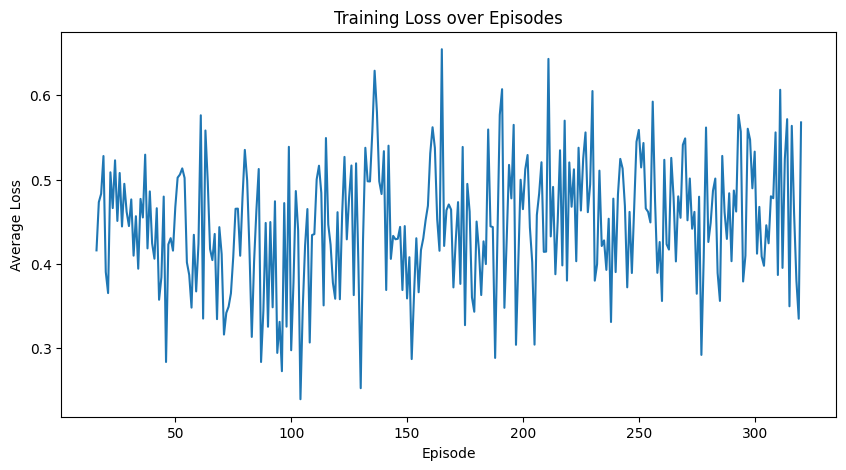

In [22]:
# Cell 11:
plt.figure(figsize=(10, 5))
plt.plot(range(batch_size, num_episodes + 1), losses)
plt.xlabel('Episode')
plt.ylabel('Average Loss')
plt.title('Training Loss over Episodes')
plt.show()


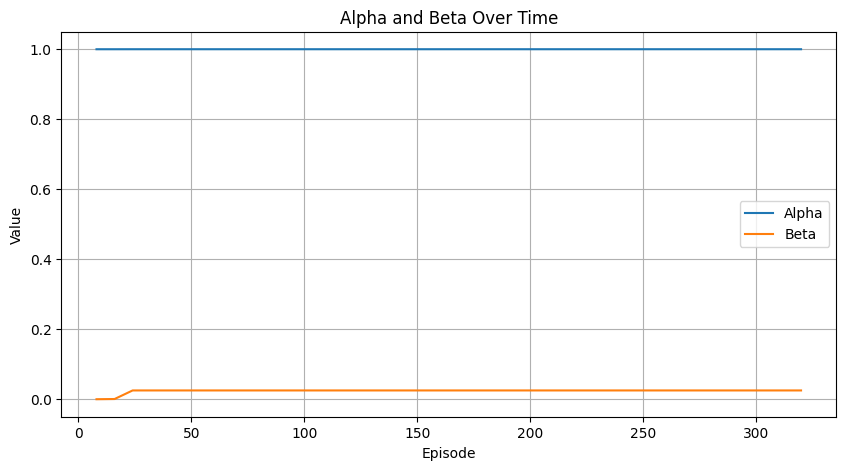

In [23]:
# Cell 12:
plt.figure(figsize=(10, 5))
plt.plot(episode_history, alpha_history, label='Alpha')
plt.plot(episode_history, beta_history, label='Beta')
plt.xlabel('Episode')
plt.ylabel('Value')
plt.title('Alpha and Beta Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Cell 13:
# Đánh giá model cuối cùng (wrapper model đã hiệu chỉnh)
print("\n--- Đánh giá Model sau khi hiệu chỉnh Bias ---")
evaluate_model(model, env, num_episodes=1000, device=device)


--- Đánh giá Model sau khi hiệu chỉnh Bias ---
Đang đánh giá trên device: cuda
Đang đánh giá... Kiến trúc Multi-Head (N=3 honeypots, M=9 nút)
--- Episode 50: Failed ---
['Web Server', 'Router']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

--- Episode 100: Failed ---
['Web Server', 'Data Server']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

Đã hoàn thành 100/1000 episodes...
--- Episode 150: Success ---
['Host 1', 'Host 2', 'File Server', 'Honeypot {Host 1}']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

--- Episode 200: Success ---
['New node', 'Honeypot {New node}']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

Đã hoàn thành 200/1000 episodes...
--- Episode 250: Failed ---
['Host 1', 'Pad', 'Web Server', 'New node', 'Host 3', 'Data Server']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

--- Episode 300: Success ---
['Host 1', 'Honeypot {Host 1}']
Honeypots connected to: ['Pad', 'New node', 'Host 1']

Đã hoàn thành 300/1000 episodes...
---